# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# !pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='data/Reacher_Option1/Reacher.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='data/Reacher_Option2/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.16349999634549023


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
from D4PG_agent import Agent, ReplayBuffer, BUFFER_SIZE, BATCH_SIZE
import random
import torch
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import progressbar as pb

In [8]:
random_seed = 7
agents = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)

In [9]:
def d4pg(n_episodes=120, max_t=1000, print_every=10, learn_every=20, num_learn=10, goal_score=30):
    total_scores_deque = deque(maxlen=100)
    total_scores = []
    total_average_scores = []
    total_time = 0
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes+1).start()
    
    for i_episode in range(1, n_episodes+1):
        # Reset Env and Agent
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                           # initialize the score (for each agent)
        
        start_time = time.time()                                # initialize timer
        
        for t in range(max_t):
            actions = agents.act(states)
            
            env_info = env.step(actions)[brain_name]            # begin environment and send all of actions
            next_states = env_info.vector_observations          # get next states (for each agent)
            rewards = env_info.rewards                          # get rewards (for each agent)
            
            dones = env_info.local_done                         # see if episode finished
            
            # *multiple agent!
            agents.step(states, actions, rewards, next_states, dones, t, num_learn)

            scores += env_info.rewards                          # update the score (for each agent)
            states = next_states                                # pdate the state (s <- s') to next time step
            
            if np.any(dones):                                   # exit loop if episode finished
                break
    
        mean_score = np.mean(scores)
        total_scores_deque.append(mean_score)
        total_scores.append(mean_score)
        total_average_score = np.mean(total_scores_deque)
        total_average_scores.append(total_average_score)
        end_time = time.time() - start_time
        total_time += end_time
        print('Episode {}, Total Average Score: {:.2f}, Mean: {:.2f}, Total Time: {:.2f}second'.format(i_episode, total_average_score, mean_score, total_time))

        if i_episode % print_every == 0: # checkpoint at print_every
            print('Episode {}\tTotal Average Score: {:.2f}'.format(i_episode, total_average_score))  
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            
            
        if total_average_score >= goal_score: # checkpoint if it reach
            print('Problem Solved after {} epsisodes!! Total Average score: {:.2f}'.format(i_episode, total_average_score))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
        timer.update(i_episode+1)
    
    return total_scores, total_average_scores

scores, total_avg_scores = d4pg()

Episode 1, Total Average Score: 0.56, Mean: 0.56, Total Time: 13.58second


Episode 2, Total Average Score: 0.75, Mean: 0.94, Total Time: 27.64second


Episode 3, Total Average Score: 0.78, Mean: 0.83, Total Time: 41.92second


Episode 4, Total Average Score: 0.84, Mean: 1.05, Total Time: 57.10second


Episode 5, Total Average Score: 0.89, Mean: 1.06, Total Time: 72.31second


Episode 6, Total Average Score: 0.93, Mean: 1.15, Total Time: 87.16second


Episode 7, Total Average Score: 0.99, Mean: 1.31, Total Time: 101.95second


Episode 8, Total Average Score: 1.01, Mean: 1.21, Total Time: 116.88second


Episode 9, Total Average Score: 1.04, Mean: 1.29, Total Time: 132.81second


Episode 10, Total Average Score: 1.01, Mean: 0.75, Total Time: 148.65second
Episode 10	Total Average Score: 1.01


Episode 11, Total Average Score: 1.01, Mean: 1.01, Total Time: 165.63second


Episode 12, Total Average Score: 1.01, Mean: 1.01, Total Time: 182.52second


Episode 13, Total Average Score: 1.00, Mean: 0.87, Total Time: 199.68second


Episode 14, Total Average Score: 1.02, Mean: 1.24, Total Time: 216.03second


Episode 15, Total Average Score: 1.05, Mean: 1.52, Total Time: 233.57second


Episode 16, Total Average Score: 1.11, Mean: 1.95, Total Time: 251.87second


Episode 17, Total Average Score: 1.17, Mean: 2.10, Total Time: 270.37second


Episode 18, Total Average Score: 1.25, Mean: 2.69, Total Time: 289.50second


Episode 19, Total Average Score: 1.32, Mean: 2.63, Total Time: 308.55second


Episode 20, Total Average Score: 1.44, Mean: 3.69, Total Time: 327.67second
Episode 20	Total Average Score: 1.44


Episode 21, Total Average Score: 1.56, Mean: 3.84, Total Time: 347.33second


Episode 22, Total Average Score: 1.74, Mean: 5.57, Total Time: 367.11second


Episode 23, Total Average Score: 1.84, Mean: 3.99, Total Time: 387.21second


Episode 24, Total Average Score: 1.93, Mean: 4.00, Total Time: 408.20second


Episode 25, Total Average Score: 2.05, Mean: 5.06, Total Time: 429.66second


Episode 26, Total Average Score: 2.22, Mean: 6.51, Total Time: 451.05second


Episode 27, Total Average Score: 2.40, Mean: 6.99, Total Time: 473.03second


Episode 28, Total Average Score: 2.57, Mean: 7.17, Total Time: 495.29second


Episode 29, Total Average Score: 2.69, Mean: 6.12, Total Time: 517.77second


Episode 30, Total Average Score: 2.88, Mean: 8.42, Total Time: 541.58second
Episode 30	Total Average Score: 2.88


Episode 31, Total Average Score: 3.09, Mean: 9.16, Total Time: 564.95second


Episode 32, Total Average Score: 3.23, Mean: 7.73, Total Time: 588.90second


Episode 33, Total Average Score: 3.43, Mean: 9.91, Total Time: 612.96second


Episode 34, Total Average Score: 3.71, Mean: 12.70, Total Time: 637.55second


Episode 35, Total Average Score: 4.05, Mean: 15.85, Total Time: 662.68second


Episode 36, Total Average Score: 4.64, Mean: 25.06, Total Time: 688.26second


Episode 37, Total Average Score: 5.32, Mean: 29.85, Total Time: 713.95second


Episode 38, Total Average Score: 6.06, Mean: 33.43, Total Time: 740.20second


Episode 39, Total Average Score: 6.78, Mean: 34.29, Total Time: 767.40second


Episode 40, Total Average Score: 7.45, Mean: 33.70, Total Time: 794.26second
Episode 40	Total Average Score: 7.45


Episode 41, Total Average Score: 8.18, Mean: 37.16, Total Time: 821.71second


Episode 42, Total Average Score: 8.90, Mean: 38.25, Total Time: 849.08second


Episode 43, Total Average Score: 9.58, Mean: 38.24, Total Time: 877.08second


Episode 44, Total Average Score: 10.25, Mean: 39.00, Total Time: 905.23second


Episode 45, Total Average Score: 10.89, Mean: 39.04, Total Time: 933.06second


Episode 46, Total Average Score: 11.50, Mean: 39.17, Total Time: 962.65second


Episode 47, Total Average Score: 12.09, Mean: 39.38, Total Time: 991.96second


Episode 48, Total Average Score: 12.66, Mean: 39.29, Total Time: 1020.81second


Episode 49, Total Average Score: 13.21, Mean: 39.50, Total Time: 1051.12second


Episode 50, Total Average Score: 13.73, Mean: 39.36, Total Time: 1082.03second
Episode 50	Total Average Score: 13.73


Episode 51, Total Average Score: 14.24, Mean: 39.47, Total Time: 1112.82second


Episode 52, Total Average Score: 14.72, Mean: 39.46, Total Time: 1143.86second


Episode 53, Total Average Score: 15.19, Mean: 39.48, Total Time: 1174.18second


Episode 54, Total Average Score: 15.64, Mean: 39.46, Total Time: 1204.99second


Episode 55, Total Average Score: 16.07, Mean: 39.49, Total Time: 1236.01second


Episode 56, Total Average Score: 16.49, Mean: 39.50, Total Time: 1266.16second


Episode 57, Total Average Score: 16.89, Mean: 39.31, Total Time: 1297.70second


Episode 58, Total Average Score: 17.28, Mean: 39.25, Total Time: 1328.84second


Episode 59, Total Average Score: 17.65, Mean: 39.47, Total Time: 1359.59second


Episode 60, Total Average Score: 18.01, Mean: 39.37, Total Time: 1390.31second
Episode 60	Total Average Score: 18.01


Episode 61, Total Average Score: 18.36, Mean: 39.31, Total Time: 1420.69second


Episode 62, Total Average Score: 18.70, Mean: 39.46, Total Time: 1451.14second


Episode 63, Total Average Score: 19.03, Mean: 39.44, Total Time: 1481.52second


Episode 64, Total Average Score: 19.35, Mean: 39.37, Total Time: 1512.06second


Episode 65, Total Average Score: 19.66, Mean: 39.43, Total Time: 1543.08second


Episode 66, Total Average Score: 19.96, Mean: 39.42, Total Time: 1573.90second


Episode 67, Total Average Score: 20.25, Mean: 39.37, Total Time: 1605.53second


Episode 68, Total Average Score: 20.53, Mean: 39.42, Total Time: 1637.63second


Episode 69, Total Average Score: 20.80, Mean: 39.39, Total Time: 1668.58second


Episode 70, Total Average Score: 21.07, Mean: 39.25, Total Time: 1699.08second
Episode 70	Total Average Score: 21.07


Episode 71, Total Average Score: 21.32, Mean: 39.20, Total Time: 1729.82second


Episode 72, Total Average Score: 21.57, Mean: 39.21, Total Time: 1760.20second


Episode 73, Total Average Score: 21.81, Mean: 39.09, Total Time: 1790.06second


Episode 74, Total Average Score: 22.05, Mean: 39.25, Total Time: 1820.77second


Episode 75, Total Average Score: 22.28, Mean: 39.30, Total Time: 1851.77second


Episode 76, Total Average Score: 22.50, Mean: 39.25, Total Time: 1882.88second


Episode 77, Total Average Score: 22.72, Mean: 39.36, Total Time: 1913.82second


Episode 78, Total Average Score: 22.93, Mean: 38.89, Total Time: 1944.39second


Episode 79, Total Average Score: 23.13, Mean: 38.70, Total Time: 1975.80second


Episode 80, Total Average Score: 23.33, Mean: 39.49, Total Time: 2007.01second
Episode 80	Total Average Score: 23.33


Episode 81, Total Average Score: 23.53, Mean: 39.44, Total Time: 2038.18second


Episode 82, Total Average Score: 23.72, Mean: 39.48, Total Time: 2069.29second


Episode 83, Total Average Score: 23.91, Mean: 39.39, Total Time: 2100.36second


Episode 84, Total Average Score: 24.10, Mean: 39.46, Total Time: 2131.73second


Episode 85, Total Average Score: 24.28, Mean: 39.44, Total Time: 2163.27second


Episode 86, Total Average Score: 24.46, Mean: 39.55, Total Time: 2194.59second


Episode 87, Total Average Score: 24.63, Mean: 39.50, Total Time: 2225.02second


Episode 88, Total Average Score: 24.80, Mean: 39.38, Total Time: 2256.89second


Episode 89, Total Average Score: 24.96, Mean: 39.44, Total Time: 2287.99second


Episode 90, Total Average Score: 25.12, Mean: 39.39, Total Time: 2320.39second
Episode 90	Total Average Score: 25.12


Episode 91, Total Average Score: 25.27, Mean: 38.88, Total Time: 2351.22second


Episode 92, Total Average Score: 25.42, Mean: 39.29, Total Time: 2381.96second


Episode 93, Total Average Score: 25.57, Mean: 38.95, Total Time: 2412.23second


Episode 94, Total Average Score: 25.72, Mean: 39.37, Total Time: 2444.04second


Episode 95, Total Average Score: 25.86, Mean: 39.35, Total Time: 2475.34second


Episode 96, Total Average Score: 26.00, Mean: 38.84, Total Time: 2507.21second


Episode 97, Total Average Score: 26.13, Mean: 39.31, Total Time: 2538.81second


Episode 98, Total Average Score: 26.27, Mean: 39.22, Total Time: 2570.34second


Episode 99, Total Average Score: 26.40, Mean: 39.19, Total Time: 2601.51second


Episode 100, Total Average Score: 26.53, Mean: 39.20, Total Time: 2631.98second
Episode 100	Total Average Score: 26.53


Episode 101, Total Average Score: 26.90, Mean: 38.44, Total Time: 2663.27second


Episode 102, Total Average Score: 27.23, Mean: 33.22, Total Time: 2694.33second


Episode 103, Total Average Score: 27.57, Mean: 35.29, Total Time: 2725.93second


Episode 104, Total Average Score: 27.93, Mean: 37.26, Total Time: 2757.31second


Episode 105, Total Average Score: 28.31, Mean: 38.77, Total Time: 2789.20second


Episode 106, Total Average Score: 28.64, Mean: 34.23, Total Time: 2820.90second


Episode 107, Total Average Score: 29.00, Mean: 37.14, Total Time: 2852.00second


Episode 108, Total Average Score: 29.38, Mean: 38.99, Total Time: 2883.39second


Episode 109, Total Average Score: 29.75, Mean: 38.76, Total Time: 2915.09second
Episode 110, Total Average Score: 30.14, Mean: 39.06, Total Time: 2946.20second
Episode 110	Total Average Score: 30.14
Problem Solved after 110 epsisodes!! Total Average score: 30.14


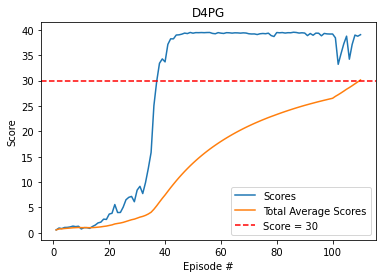

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='Scores')
plt.plot(np.arange(1, len(scores)+1), total_avg_scores, label='Total Average Scores')
plt.title("D4PG")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.axhline(y=30, color='r', linestyle='--', label='Score = 30')
plt.legend(loc='best')
plt.savefig('D4PG.png')
plt.savefig('D4PG.pdf')
plt.show()

In [11]:
# Load the saved weights into Pytorch model
agents.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = agents.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score: {}'.format(np.mean(scores)))

Total score: 39.37649911986664


In [12]:
env.close()